In [ ]:
import numpy
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.callbacks import EarlyStopping

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
data=pd.read_csv("/content/drive/My Drive/KMMI/inflasi.csv",usecols=[0,1],engine='python')
data['Waktu'] = pd.to_datetime(data['Waktu'])
data.tail()

MessageError: ignored

Text(0, 0.5, 'Inflation')

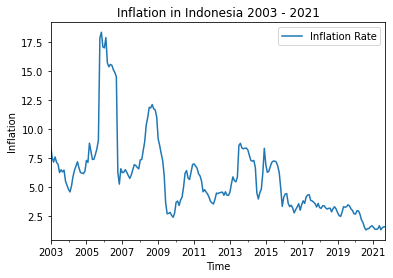

In [ ]:
import matplotlib.pyplot as plt
data.plot(x ='Waktu', y='Inflation Rate')
plt.title('Inflation in Indonesia 2003 - 2021')
plt.xlabel('Time')
plt.ylabel('Inflation')

In [ ]:
# normalize the dataset
dataset=data['Inflation Rate'].values
dataset=dataset.astype('float32')
dataset=numpy.reshape(dataset,(-1,1))
scaler=MinMaxScaler(feature_range=(0,1))
dataset=scaler.fit_transform(dataset)

In [ ]:
# split into train and test sets
train_size = int(len(dataset) * 0.70)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(train_size)
print(test_size)

157
68


In [ ]:
#Create Dataset Function
def create_dataset(dataset,look_back):
  X,Y=[],[]
  for i in range (len(dataset)-look_back-1):
    a=dataset[i:(i+look_back),0]
    X.append(a)
    Y.append(dataset[i+look_back,0])
  return numpy.array(X),numpy.array(Y)

# reshape into X=t and Y=t+1
look_back = 12
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))

learning_rate=0.01
batch_size=10
neuron_unit=5

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(neuron_unit, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(1,activation='tanh',kernel_initializer='glorot_uniform',bias_initializer='zero',use_bias=True))
opt=keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(loss='mean_squared_error', optimizer=opt)
history=model.fit(trainX, trainY, epochs=100, batch_size=batch_size, validation_data=(testX,testY),
          callbacks=[EarlyStopping(monitor='val_loss',patience=10)],verbose=2, shuffle=False)
model.reset_states()
model.summary()

# make predictions
trainPredict = model.predict(trainX)
model.reset_states()
testPredict = model.predict(testX)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Epoch 1/100
15/15 - 3s - loss: 0.0513 - val_loss: 0.0238 - 3s/epoch - 182ms/step
Epoch 2/100
15/15 - 0s - loss: 0.0208 - val_loss: 0.0041 - 133ms/epoch - 9ms/step
Epoch 3/100
15/15 - 0s - loss: 0.0217 - val_loss: 0.0068 - 124ms/epoch - 8ms/step
Epoch 4/100
15/15 - 0s - loss: 0.0172 - val_loss: 0.0022 - 121ms/epoch - 8ms/step
Epoch 5/100
15/15 - 0s - loss: 0.0161 - val_loss: 0.0015 - 134ms/epoch - 9ms/step
Epoch 6/100
15/15 - 0s - loss: 0.0143 - val_loss: 7.5147e-04 - 123ms/epoch - 8ms/step
Epoch 7/100
15/15 - 0s - loss: 0.0132 - val_loss: 5.8926e-04 - 127ms/epoch - 8ms/step
Epoch 8/100
15/15 - 0s - loss: 0.0121 - val_loss: 4.9053e-04 - 135ms/epoch - 9ms/step
Epoch 9/100
15/15 - 0s - loss: 0.0111 - val_loss: 4.9627e-04 - 136ms/epoch - 9ms/step
Epoch 10/100
15/15 - 0s - loss: 0.0102 - val_loss: 5.3539e-04 - 132ms/epoch - 9ms/step
Epoch 11/100
15/15 - 0s - loss: 0.0095 - val_loss: 5.7324e-04 - 119ms/epoch - 8ms/step
Epoch 12/100
15/15 - 0s - loss: 0.0092 - val_loss: 5.5627e-04 - 127ms/epo

In [ ]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

In [ ]:
print(testY.shape)

(1, 55)


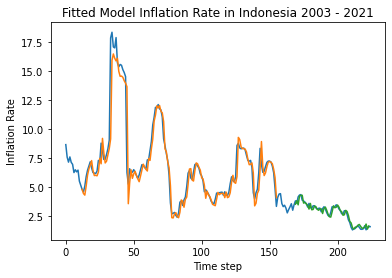

In [ ]:
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.title('Fitted Model Inflation Rate in Indonesia 2003 - 2021')
plt.xlabel('Time step')
plt.ylabel('Inflation Rate')
plt.show()

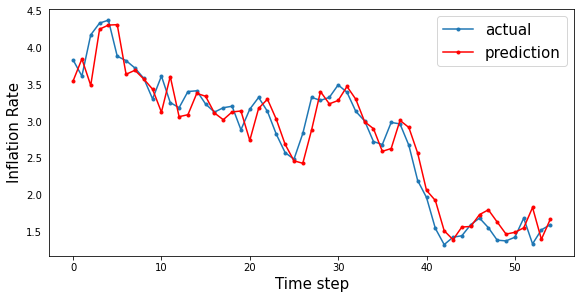

In [ ]:
#Plot Prediction
aa=[x for x in range(55)]
plt.figure(figsize=(8,4))
plt.plot(aa,testY[0][:55],marker='.',label="actual")
plt.plot(aa,testPredict[:,0][:55],'r',marker='.',label="prediction")
plt.tick_params(left=False,labelleft=True) #remove ticks
plt.tight_layout()
plt.subplots_adjust(left=0.07)
plt.ylabel('Inflation Rate',size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()

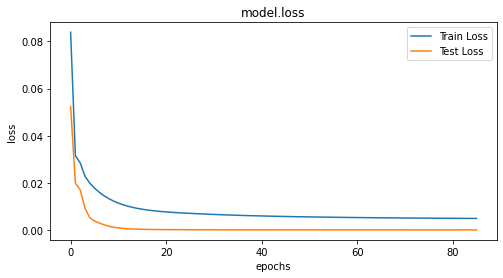

In [ ]:
#Plot loss
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'],label='Train Loss')
plt.plot(history.history['val_loss'],label='Test Loss')
plt.title('model.loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

In [ ]:
X_FUTURE = 13
predictions = numpy.array([])
last = testX[-1]
for i in range(X_FUTURE):
  curr_prediction = model.predict(numpy.array([last]))
  last = numpy.concatenate([last[1:], curr_prediction])
  predictions = numpy.concatenate([predictions, curr_prediction[0]])
predictions = scaler.inverse_transform([predictions])[0]
print(predictions)

[1.46919065 1.44844571 1.43127517 1.41397852 1.39674663 1.38004398
 1.36432443 1.35002275 1.33743335 1.32665933 1.317605   1.31022937
 1.3044612 ]
